# Home Credit Individual Notebook

## Griffin Brown

## TOC
* [Introduction](#introduction)
* [Load Data](#load_data)
* [Clean Function](#function)
* [Additional Datasets](#datasets)
    * [Bureau](#bureau)
    * [POS Cash Balance](#pcb)
    * [Install Payments](#payments)
    * [Previous Application](#prev)
* [Preparing For Testing](#prep)
    * [Upsampling](#upsampling)
    * [LightGBM](#light)
    * [XGBoost](#xgboost)
    * [Random Forest](#rand_f) 
    * [ANN](#ann) 

## Introduction <a class="anchor" id="introduction"></a>

This notebook acts as my individual modeling work for the Home Credit project. 

My best score was an AUC of 0.781 using a LightGBM model with no upsampling.

## Load Packages

In [133]:
import pandas as pd
import numpy as np
import os
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import plot_tree
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
from scipy.stats import logistic
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense


pd.set_option('display.max_columns', None)

## Load Data <a class="anchor" id="load_data"></a>

In [134]:
train_url = 'https://storage.googleapis.com/home_credit_files/application_train.csv'
test_url = 'https://storage.googleapis.com/home_credit_files/application_test.csv'
bureau_url = 'https://storage.googleapis.com/home_credit_files/bureau.csv'
bureau_balance_url = 'https://storage.googleapis.com/home_credit_files/bureau_balance.csv'
POS_CASH_balance_url = 'https://storage.googleapis.com/home_credit_files/POS_CASH_balance.csv'
previous_application_url = 'https://storage.googleapis.com/home_credit_files/previous_application.csv'
installments_payments_url = 'https://storage.googleapis.com/home_credit_files/installments_payments.csv'

In [135]:
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

C:\Users\gbrown\AppData\Local\Temp\ipykernel_9784\474926630.py:1: DtypeWarning: Columns (90) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_url)


Split data.

In [136]:
train_df['test'] = False 
train_df['train'] = True
test_df['test'] = True
test_df['train'] = False

In [137]:
y = train_df['TARGET']
train_X = train_df.drop(['TARGET'], axis = 1)

test_id = test_df['SK_ID_CURR']
test_X = test_df

full_df = pd.concat([train_X, test_X], axis=0)

In [138]:
full_df.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,356255.000000,356255.000000,3.562550e+05,3.562550e+05,356219.000000,3.559770e+05,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,121014.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356253.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,162345.000000,3.555870e+05,286622.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,176307.000000,148671.000000,183392.000000,119949.000000,107895.000000,167175.000000,177848.000000,179914.000000,115147.000000,145411.000000,113276.000000,178353.000000,109394.000000,160489.000000,185200.000000,355205.000000,355205.000000,355205.000000,355205.000000,356254.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.000000,356255.00000,356255.000000,356255.000000,356255.000000,356255.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000,308687.000000
mean,278128.000000,0.414316,1.701161e+05,5.877674e+05,27425.560657,5.280200e+05,0.020917,-16041.248841,64317.231413,-4983.593527,-3002.071163,12.023741,0.999994,0.818498,0.200098,0.998170,0.278612,0.071213,2.151858,2.050506,2.028932,12.055749,0.015649,0.051371,0.040847,0.078076,0.229661,0.178824,0.501965,5.148900e-01,0.509350,0.118138,0.088673,0.977889,0.752283,0.045045,0.079819,0.150015,0.227331,0.232817,0.066454,0.101495,0.108089,0.008868,0.028503,0.114914,0.087750,0.977239,0.759452,0.042930,0.075346,0.145471,0.223315,0.228878,0.065092,0.106382,0.106641,0.008116,0.027183,0.118549,0.088178,0.977903,0.755548,0.

Replace a weird value that is seen throughout the data. Create some new features.

In [139]:
full_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
full_df['employment_perc'] = full_df['DAYS_EMPLOYED']/(full_df['DAYS_BIRTH']-(16*365))
full_df['credit_perc'] = full_df['AMT_INCOME_TOTAL']/full_df['AMT_CREDIT']
full_df['income_per_family'] = full_df['AMT_INCOME_TOTAL']/full_df['CNT_FAM_MEMBERS']

C:\Users\gbrown\AppData\Local\Temp\ipykernel_9784\3055087298.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  full_df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)


## Clean Function <a class="anchor" id="function"></a>

This will clean and create dummy variables across the datasets.

In [140]:
def preprocess_dataframe(df):
    object_cols = df.select_dtypes(include='object').columns.to_list()
    for col in object_cols:
        df[col] = df[col].astype('category')

    category_cols = [col for col in df.columns if df[col].dtype == 'category']

    for col in category_cols:
        df[col], _ = pd.factorize(df[col])

    for col in category_cols:
        dummies = pd.get_dummies(df[col], dummy_na=True, prefix=col)
        df = pd.concat([df.drop(col, axis=1), dummies], axis=1)

    return df

In [141]:
full_df = preprocess_dataframe(full_df)
print(full_df.dtypes.value_counts())
print(full_df.shape)

bool       170
float64     69
int64       39
Name: count, dtype: int64
(356255, 278)


## Additional Datasets <a class="anchor" id="datasets"></a>

## Bureau <a class="anchor" id="bureau"></a>

In [142]:
bureau = pd.read_csv(bureau_url)
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [143]:
print(bureau.dtypes.value_counts())
print(bureau.shape)
bureau.head()

float64    8
int64      6
object     3
Name: count, dtype: int64
(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [144]:
bureau = preprocess_dataframe(bureau)
print(bureau.dtypes.value_counts())
print(bureau.shape)
bureau.head()

bool       26
float64     8
int64       6
Name: count, dtype: int64
(1716428, 40)


,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,CREDIT_ACTIVE_0.0,CREDIT_ACTIVE_1.0,CREDIT_ACTIVE_2.0,CREDIT_ACTIVE_3.0,CREDIT_ACTIVE_nan,CREDIT_CURRENCY_0.0,CREDIT_CURRENCY_1.0,CREDIT_CURRENCY_2.0,CREDIT_CURRENCY_3.0,CREDIT_CURRENCY_nan,CREDIT_TYPE_0.0,CREDIT_TYPE_1.0,CREDIT_TYPE_2.0,CREDIT_TYPE_3.0,CREDIT_TYPE_4.0,CREDIT_TYPE_5.0,CREDIT_TYPE_6.0,CREDIT_TYPE_7.0,CREDIT_TYPE_8.0,CREDIT_TYPE_9.0,CREDIT_TYPE_10.0,CREDIT_TYPE_11.0,CREDIT_TYPE_12.0,CREDIT_TYPE_13.0,CREDIT_TYPE_14.0,CREDIT_TYPE_nan
0,215354,5714462,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,-131,NaN,True,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,215354,5714463,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,-20,NaN,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,215354,5714464,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,-16,NaN,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,215354,5714465,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,-16,NaN,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,215354,5714466,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,-21,NaN,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [145]:
aggs = ['min', 'max', 'mean', 'var']
bureau_aggregations = {
        'DAYS_CREDIT': aggs,
        'DAYS_CREDIT_ENDDATE': aggs,
        'DAYS_CREDIT_UPDATE': aggs,
        'CREDIT_DAY_OVERDUE': aggs,
        'AMT_CREDIT_MAX_OVERDUE': aggs,
        'AMT_CREDIT_SUM': aggs,
        'AMT_CREDIT_SUM_DEBT': aggs,
        'AMT_CREDIT_SUM_OVERDUE': aggs,
        'AMT_CREDIT_SUM_LIMIT': aggs,
        'AMT_ANNUITY': aggs,
        'CNT_CREDIT_PROLONG': aggs
}

Create aggregations that we will use across the datasets.

Note: This could be looked at closer, as not all of the aggregation formulas may make sense to apply to every predictor chosen.

In [146]:
aggregated_bureau = bureau.groupby('SK_ID_CURR').agg(bureau_aggregations)

aggregated_bureau.columns = ['_'.join(col).strip() for col in aggregated_bureau.columns.values]

aggregated_bureau.reset_index(inplace=True)

aggregated_bureau

,SK_ID_CURR,DAYS_CREDIT_min,DAYS_CREDIT_max,DAYS_CREDIT_mean,DAYS_CREDIT_var,DAYS_CREDIT_ENDDATE_min,DAYS_CREDIT_ENDDATE_max,DAYS_CREDIT_ENDDATE_mean,DAYS_CREDIT_ENDDATE_var,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_UPDATE_max,DAYS_CREDIT_UPDATE_mean,DAYS_CREDIT_UPDATE_var,CREDIT_DAY_OVERDUE_min,CREDIT_DAY_OVERDUE_max,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_var,AMT_CREDIT_MAX_OVERDUE_min,AMT_CREDIT_MAX_OVERDUE_max,AMT_CREDIT_MAX_OVERDUE_mean,AMT_CREDIT_MAX_OVERDUE_var,AMT_CREDIT_SUM_min,AMT_CREDIT_SUM_max,AMT_CREDIT_SUM_mean,AMT_CREDIT_SUM_var,AMT_CREDIT_SUM_DEBT_min,AMT_CREDIT_SUM_DEBT_max,AMT_CREDIT_SUM_DEBT_mean,AMT_CREDIT_SUM_DEBT_var,AMT_CREDIT_SUM_OVERDUE_min,AMT_CREDIT_SUM_OVERDUE_max,AMT_CREDIT_SUM_OVERDUE_mean,AMT_CREDIT_SUM_OVERDUE_var,AMT_CREDIT_SUM_LIMIT_min,AMT_CREDIT_SUM_LIMIT_max,AMT_CREDIT_SUM_LIMIT_mean,AMT_CREDIT_SUM_LIMIT_var,AMT_ANNUITY_min,AMT_ANNUITY_max,AMT_ANNUITY_mean,AMT_ANNUITY_var,CNT_CREDIT_PROLONG_min,CNT_CREDIT_PROLONG_max,CNT_CREDIT_PROLONG_mean,CNT_CREDIT_PROLONG_var
0,100001,-1572,-49,-735.000000,240043.666667,-1329.0,1778.0,82.428571,1.066798e+06,-155,-6,-93.142857,5960.476190,0,0,0.0,0.0,NaN,NaN,NaN,NaN,85500.0,378000.00,2.076236e+05,1.501717e+10,0.0,373239.00,85240.928571,1.890230e+10,0.0,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000e+00,0.000,10822.5,3545.357143,2.304583e+07,0,0,0.000000,0.000000
1,100002,-1437,-103,-874.000000,186150.000000,-1072.0,780.0,-349.000000,5.890424e+05,-1185,-7,-499.875000,268865.553571,0,0,0.0,0.0,0.0,5043.645,1681.029,5.584936e+06,0.0,450000.00,1.081319e+05,2.133807e+10,0.0,245781.00,49156.200000,1.208166e+10,0.0,0.0,0.0,0.0,0.0,31988.565,7997.14125,2.558171e+08,0.000,0.0,0.000000,0.000000e+00,0,0,0.000000,0.000000
2,100003,-2586,-606,-1400.750000,827783.583333,-2434.0,1216.0,-544.500000,2.228364e+06,-2131,-43,-816.000000,824562.000000,0,0,0.0,0.0,0.0,0.000,0.000,0.000000e+00,22248.0,810000.00,2.543501e+05,1.385846e+11,0.0,0.00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,810000.000,202500.00000,1.640250e+11,NaN,NaN,NaN,NaN,0,0,0.000000,0.000000
3,100004,-1326,-408,-867.000000,421362.000000,-595.0,-382.0,-488.500000,2.268450e+04,-682,-382,-532.000000,45000.000000,0,0,0.0,0.0,0.0,0.000,0.000,NaN,94500.0,94537.80,9.451890e+04,7.144200e+02,0.0,0.00,0.000000,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000e+00,NaN,NaN,NaN,NaN,0,0,0.000000,0.000000
4,100005,-373,-62,-190.666667,26340.333333,-128.0,1324.0,439.333333,6.026013e+05,-121,-11,-54.333333,3433.333333,0,0,0.0,0.0,0.0,0.000,0.000,NaN,29826.0,568800.00,2.190420e+05,9.195354e+10,0.0,543087.00,189469.500000,9.394430e+10,0.0,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000e+00,0.000,4261.5,1420.500000,6.053461e+06,0,0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,-2713,-483,-1667.076923,407302.243590,-2499.0,1363.0,-1232.333333,9.556770e+05,-2498,-12,-1064.538462,439090.269231,0,0,0.0,0.0,0.0,18945.000,6147.000,7.724727e+07,43447.5,765000.00,2.841430e+05,4.671276e+10,0.0,163071.00,16307.100000,2.659215e+09,0.0,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000e+00,NaN,NaN,NaN,NaN,0,0,0.000000,0.000000
305807,456250,-1002,-760,-862.000000,15724.000000,-272.0,2340.0,1288.333333,1.899692e+06,-127,-23,-60.333333,3349.333333,0,0,0.0,0.0,0.0,0.000,0.000,0.000000e+00,450000.0,2153110.05,1.028820e+06,9.482994e+11,0.0,1840308.48,744013.365000,9.397606e+11,0.0,0.0,0.0,0.0,0.0,58268.385,19422.79500,1.131735e+09,27757.395,384147.0,154567.965000,3.967441e+10,0,0,0.000000,0.000000
305808,456253,-919,-713,-867.500000,10609.000000,-189.0,1113.0,280.500000,3.817530e+05,-701,-5,-253.250000,94436.250000,0,0,0.0,0.0,NaN,NaN,NaN,NaN,360000.0,2250000.00,9.900000e+05,7.276500e+11,0.0,1624797.00,448958.250000,6.209882e+11,0.0,0.0,0.0,0.0,0.0,0.000,0.00000,0.000000e+00,58369.500,58369.5,58369.500000,0.000000e+00,0,0,0.000000,0.000000
305809,456254,-1104,-1104,-1104.000000,NaN,-859.0,-859.0,-859.000

In [147]:
full_df = full_df.merge(right=aggregated_bureau, how='left', on='SK_ID_CURR')

In [148]:
#full_df = full_df.merge(right=bureau_agg.reset_index(), how='left', on='SK_ID_CURR')
full_df.dtypes.value_counts()

bool       170
float64    113
int64       39
Name: count, dtype: int64

## POS Cash Balance <a class="anchor" id="pcb"></a>

In [149]:
pcb = pd.read_csv(POS_CASH_balance_url)
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [150]:
pcb.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [151]:
pcb = preprocess_dataframe(pcb)
pcb.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF,NAME_CONTRACT_STATUS_0.0,NAME_CONTRACT_STATUS_1.0,NAME_CONTRACT_STATUS_2.0,NAME_CONTRACT_STATUS_3.0,NAME_CONTRACT_STATUS_4.0,NAME_CONTRACT_STATUS_5.0,NAME_CONTRACT_STATUS_6.0,NAME_CONTRACT_STATUS_7.0,NAME_CONTRACT_STATUS_8.0,NAME_CONTRACT_STATUS_nan
0,1803195,182943,-31,48.0,45.0,0,0,True,False,False,False,False,False,False,False,False,False
1,1715348,367990,-33,36.0,35.0,0,0,True,False,False,False,False,False,False,False,False,False
2,1784872,397406,-32,12.0,9.0,0,0,True,False,False,False,False,False,False,False,False,False
3,1903291,269225,-35,48.0,42.0,0,0,True,False,False,False,False,False,False,False,False,False
4,2341044,334279,-35,36.0,35.0,0,0,True,False,False,False,False,False,False,False,False,False


In [152]:
pcb_aggregations = {
    'MONTHS_BALANCE': aggs,
    'CNT_INSTALMENT': aggs,
    'CNT_INSTALMENT_FUTURE':aggs
}

In [153]:
aggregated_pcb = pcb.groupby('SK_ID_CURR').agg(pcb_aggregations)

aggregated_pcb.columns = ['_'.join(col).strip() for col in aggregated_pcb.columns.values]

aggregated_pcb.reset_index(inplace=True)

aggregated_pcb

,SK_ID_CURR,MONTHS_BALANCE_min,MONTHS_BALANCE_max,MONTHS_BALANCE_mean,MONTHS_BALANCE_var,CNT_INSTALMENT_min,CNT_INSTALMENT_max,CNT_INSTALMENT_mean,CNT_INSTALMENT_var,CNT_INSTALMENT_FUTURE_min,CNT_INSTALMENT_FUTURE_max,CNT_INSTALMENT_FUTURE_mean,CNT_INSTALMENT_FUTURE_var
0,100001,-96,-53,-72.555556,435.277778,4.0,4.0,4.000000,0.000000,0.0,4.0,1.444444,2.027778
1,100002,-19,-1,-10.000000,31.666667,24.0,24.0,24.000000,0.000000,6.0,24.0,15.000000,31.666667
2,100003,-77,-18,-43.785714,607.137566,6.0,12.0,10.107143,7.876984,0.0,12.0,5.785714,14.767196
3,100004,-27,-24,-25.500000,1.666667,3.0,4.0,3.750000,0.250000,0.0,4.0,2.250000,2.916667
4,100005,-25,-15,-20.000000,11.000000,9.0,12.0,11.700000,0.900000,0.0,12.0,7.200000,13.066667
...,...,...,...,...,...,...,...,...,...,...,...,...,...
337247,456251,-9,-1,-5.000000,7.500000,7.0,8.0,7.875000,0.125000,0.0,8.0,4.375000,7.125000
337248,456252,-82,-76,-79.000000,4.666667,6.0,6.0,6.000000,0.000000,0.0,6.0,3.000000,4.666667
337249,456253,-96,-57,-79.235294,279.691176,4.0,12.0,6.705882,9.970588,0.0,6.0,2.000000,3.625000
337250,456254,-11,-1,-5.550000,9.207895,14.0,16.0,14.900000,1.042105,4.0,16.0,10.350000,11.292105


In [154]:
full_df = full_df.merge(right=aggregated_pcb, how='left', on='SK_ID_CURR')
full_df.dtypes.value_counts()

bool       170
float64    125
int64       39
Name: count, dtype: int64

## Install Payments <a class="anchor" id="install"></a>

In [181]:
ip = pd.read_csv(installments_payments_url)
ip.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [182]:
ip = preprocess_dataframe(ip)
ip.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [157]:
ip = ip.drop(['NUM_INSTALMENT_VERSION', 'NUM_INSTALMENT_NUMBER'], axis=1)
ip['payment_perc'] = ip['AMT_PAYMENT'] / ip['AMT_INSTALMENT']
ip['payment_var'] = ip['AMT_INSTALMENT'] - ip['AMT_PAYMENT']
ip['days_passed_due'] = ip['DAYS_ENTRY_PAYMENT'] - ip['DAYS_INSTALMENT']

In [158]:
ip_aggregations = {
    'DAYS_INSTALMENT': aggs,
    'DAYS_ENTRY_PAYMENT': aggs,
    'AMT_INSTALMENT': aggs,
    'AMT_PAYMENT': aggs,
    'payment_perc': aggs,
    'payment_var': aggs,
    'days_passed_due': aggs
}

In [159]:
aggregated_ip = ip.groupby('SK_ID_CURR').agg(ip_aggregations)

aggregated_ip.columns = ['_'.join(col).strip() for col in aggregated_ip.columns.values]

aggregated_ip.reset_index(inplace=True)

aggregated_ip

,SK_ID_CURR,DAYS_INSTALMENT_min,DAYS_INSTALMENT_max,DAYS_INSTALMENT_mean,DAYS_INSTALMENT_var,DAYS_ENTRY_PAYMENT_min,DAYS_ENTRY_PAYMENT_max,DAYS_ENTRY_PAYMENT_mean,DAYS_ENTRY_PAYMENT_var,AMT_INSTALMENT_min,AMT_INSTALMENT_max,AMT_INSTALMENT_mean,AMT_INSTALMENT_var,AMT_PAYMENT_min,AMT_PAYMENT_max,AMT_PAYMENT_mean,AMT_PAYMENT_var,payment_perc_min,payment_perc_max,payment_perc_mean,payment_perc_var,payment_var_min,payment_var_max,payment_var_mean,payment_var_var,days_passed_due_min,days_passed_due_max,days_passed_due_mean,days_passed_due_var
0,100001,-2916.0,-1619.0,-2187.714286,427702.571429,-2916.0,-1628.0,-2195.000000,414612.666667,3951.000,17397.900,5885.132143,2.577265e+07,3951.000,17397.900,5885.132143,2.577265e+07,1.000000,1.00000,1.000000,0.000000,0.000,0.000,0.00000,0.000000e+00,-36.0,11.0,-7.285714,213.904762
1,100002,-565.0,-25.0,-295.000000,28500.000000,-587.0,-49.0,-315.421053,29604.257310,9251.775,53093.745,11559.247105,1.011641e+08,9251.775,53093.745,11559.247105,1.011641e+08,1.000000,1.00000,1.000000,0.000000,0.000,0.000,0.00000,0.000000e+00,-31.0,-12.0,-20.421053,24.257310
2,100003,-2310.0,-536.0,-1378.160000,573735.890000,-2324.0,-544.0,-1385.320000,573541.810000,6662.970,560835.360,64754.586000,1.221966e+10,6662.970,560835.360,64754.586000,1.221966e+10,1.000000,1.00000,1.000000,0.000000,0.000,0.000,0.00000,0.000000e+00,-14.0,-1.0,-7.160000,13.890000
3,100004,-784.0,-724.0,-754.000000,900.000000,-795.0,-727.0,-761.666667,1157.333333,5357.250,10573.965,7096.155000,9.071372e+06,5357.250,10573.965,7096.155000,9.071372e+06,1.000000,1.00000,1.000000,0.000000,0.000,0.000,0.00000,0.000000e+00,-11.0,-3.0,-7.666667,17.333333
4,100005,-706.0,-466.0,-586.000000,6750.000000,-736.0,-470.0,-609.555556,8200.027778,4813.200,17656.245,6240.205000,1.832709e+07,4813.200,17656.245,6240.205000,1.832709e+07,1.000000,1.00000,1.000000,0.000000,0.000,0.000,0.00000,0.000000e+00,-37.0,1.0,-23.555556,182.527778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339582,456251,-210.0,-30.0,-120.000000,4200.000000,-237.0,-38.0,-156.285714,4968.238095,6605.910,12815.010,7492.924286,5.507560e+06,6605.910,12815.010,7492.924286,5.507560e+06,1.000000,1.00000,1.000000,0.000000,0.000,0.000,0.00000,0.000000e+00,-46.0,-8.0,-36.285714,198.238095
339583,456252,-2466.0,-2316.0,-2391.000000,3150.000000,-2470.0,-2327.0,-2393.833333,2866.166667,10046.880,10074.465,10069.867500,1.268220e+02,10046.880,10074.465,10069.867500,1.268220e+02,1.000000,1.00000,1.000000,0.000000,0.000,0.000,0.00000,0.000000e+00,-11.0,3.0,-2.833333,22.166667
339584,456253,-2915.0,-1716.0,-2372.928571,277339.302198,-2915.0,-1738.0,-2387.428571,268713.648352,2754.450,5575.185,4399.707857,1.312048e+06,27.270,5575.185,4115.915357,2.683793e+06,0.006864,1.00000,0.928571,0.070380,0.000,3945.825,283.79250,1.110980e+06,-51.0,9.0,-14.500000,271.038462
339585,456254,-291.0,-7.0,-142.263158,7346.315789,-317.0,-18.0,-161.263158,7619.093567,2296.440,19065.825,10239.832895,7.400323e+07,2296.440,19065.825,10239.832895,7.400323e+07,1.000000,1.00000,1.000000,0.000000,0.000,0.000,0.00000,0.000000e+00,-31.0,-8.0,-19.000000,67.222222


In [180]:
ip.describe()

c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,SK_ID_PREV,SK_ID_CURR,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,payment_perc,payment_var,days_passed_due
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07,13602494.0,1.360250e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04,inf,-1.871538e+02,-8.787405e+00
std,5.362029e+05,1.027183e+05,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04,NaN,1.910673e+04,2.553990e+01
min,1.000001e+06,1.000010e+05,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00,0.0,-2.630909e+06,-3.189000e+03
25%,1.434191e+06,1.896390e+05,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03,1.0,0.000000e+00,-1.400000e+01
50%,1.896520e+06,2.786850e+05,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03,1.0,0.000000e+00,-6.000000e+00
75%,2.369094e+06,3.675300e+05,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04,1.0,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06,inf,2.424726e+06,2.884000e+03


In [160]:
full_df = full_df.merge(right=aggregated_ip, how='left', on='SK_ID_CURR')
full_df.dtypes.value_counts()

bool       170
float64    153
int64       39
Name: count, dtype: int64

## Previous Applications <a class="anchor" id="pred"></a>

In [161]:
pa = pd.read_csv(previous_application_url)
pa.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [162]:
pa.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,5951.000000,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,0.188357,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,0.087671,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115833,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,0.034781,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,0.160716,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,0.189122,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,0.193330,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,1.000000,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [163]:
pa['DAYS_FIRST_DRAWING'] = pa['DAYS_FIRST_DRAWING'].replace(365243, np.nan)
pa['DAYS_FIRST_DUE'] = pa['DAYS_FIRST_DUE'].replace(365243, np.nan)
pa['DAYS_LAST_DUE_1ST_VERSION'] = pa['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan)
pa['DAYS_LAST_DUE'] = pa['DAYS_LAST_DUE'].replace(365243, np.nan)
pa['DAYS_TERMINATION'] = pa['DAYS_TERMINATION'].replace(365243, np.nan)
pa = pa.drop(['NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 'NAME_TYPE_SUITE', 
         'NAME_GOODS_CATEGORY', 'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 
         'SELLERPLACE_AREA', 'NAME_SELLER_INDUSTRY', 'PRODUCT_COMBINATION'], axis = 1)

In [164]:
pa = preprocess_dataframe(pa)

In [165]:
previous_application_counts = pa.groupby('SK_ID_CURR')['SK_ID_PREV'].count()
previous_application_counts

SK_ID_CURR
100001    1
100002    1
100003    3
100004    1
100005    2
         ..
456251    1
456252    1
456253    2
456254    2
456255    8
Name: SK_ID_PREV, Length: 338857, dtype: int64

In [166]:
pa = pa.merge(right=previous_application_counts, how='left', on='SK_ID_CURR')

In [167]:
pa_aggregations = {
    'AMT_ANNUITY': aggs,
    'AMT_APPLICATION': aggs,
    'AMT_CREDIT': aggs,
    'AMT_DOWN_PAYMENT': aggs,
    'AMT_GOODS_PRICE': aggs,
    'CNT_PAYMENT': aggs,
    'DAYS_DECISION': aggs
}

In [168]:
aggregated_pa = pa.groupby('SK_ID_CURR').agg(pa_aggregations)

aggregated_pa.columns = ['_'.join(col).strip() for col in aggregated_pa.columns.values]

aggregated_pa.reset_index(inplace=True)

aggregated_pa

,SK_ID_CURR,AMT_ANNUITY_min,AMT_ANNUITY_max,AMT_ANNUITY_mean,AMT_ANNUITY_var,AMT_APPLICATION_min,AMT_APPLICATION_max,AMT_APPLICATION_mean,AMT_APPLICATION_var,AMT_CREDIT_min,AMT_CREDIT_max,AMT_CREDIT_mean,AMT_CREDIT_var,AMT_DOWN_PAYMENT_min,AMT_DOWN_PAYMENT_max,AMT_DOWN_PAYMENT_mean,AMT_DOWN_PAYMENT_var,AMT_GOODS_PRICE_min,AMT_GOODS_PRICE_max,AMT_GOODS_PRICE_mean,AMT_GOODS_PRICE_var,CNT_PAYMENT_min,CNT_PAYMENT_max,CNT_PAYMENT_mean,CNT_PAYMENT_var,DAYS_DECISION_min,DAYS_DECISION_max,DAYS_DECISION_mean,DAYS_DECISION_var
0,100001,3951.000,3951.000,3951.000000,NaN,24835.5,24835.5,24835.500,NaN,23787.0,23787.0,23787.00,NaN,2520.0,2520.0,2520.00,NaN,24835.5,24835.5,24835.500,NaN,8.0,8.0,8.00,NaN,-1740,-1740,-1740.000,NaN
1,100002,9251.775,9251.775,9251.775000,NaN,179055.0,179055.0,179055.000,NaN,179055.0,179055.0,179055.00,NaN,0.0,0.0,0.00,NaN,179055.0,179055.0,179055.000,NaN,24.0,24.0,24.00,NaN,-606,-606,-606.000,NaN
2,100003,6737.310,98356.995,56553.990000,2.146706e+09,68809.5,900000.0,435436.500,1.799131e+11,68053.5,1035882.0,484191.00,2.479541e+11,0.0,6885.0,3442.50,2.370161e+07,68809.5,900000.0,435436.500,1.799131e+11,6.0,12.0,10.00,12.000000,-2341,-746,-1305.000,806653.000000
3,100004,5357.250,5357.250,5357.250000,NaN,24282.0,24282.0,24282.000,NaN,20106.0,20106.0,20106.00,NaN,4860.0,4860.0,4860.00,NaN,24282.0,24282.0,24282.000,NaN,4.0,4.0,4.00,NaN,-815,-815,-815.000,NaN
4,100005,4813.200,4813.200,4813.200000,NaN,0.0,44617.5,22308.750,9.953607e+08,0.0,40153.5,20076.75,8.061518e+08,4464.0,4464.0,4464.00,NaN,44617.5,44617.5,44617.500,NaN,12.0,12.0,12.00,NaN,-757,-315,-536.000,97682.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338852,456251,6605.910,6605.910,6605.910000,NaN,40455.0,40455.0,40455.000,NaN,40455.0,40455.0,40455.00,NaN,0.0,0.0,0.00,NaN,40455.0,40455.0,40455.000,NaN,8.0,8.0,8.00,NaN,-273,-273,-273.000,NaN
338853,456252,10074.465,10074.465,10074.465000,NaN,57595.5,57595.5,57595.500,NaN,56821.5,56821.5,56821.50,NaN,3456.0,3456.0,3456.00,NaN,57595.5,57595.5,57595.500,NaN,6.0,6.0,6.00,NaN,-2497,-2497,-2497.000,NaN
338854,456253,3973.095,5567.715,4770.405000,1.271406e+06,19413.0,28912.5,24162.750,4.512025e+07,13945.5,27306.0,20625.75,8.925148e+07,2893.5,5913.0,4403.25,4.558690e+06,19413.0,28912.5,24162.750,4.512025e+07,4.0,6.0,5.00,2.000000,-2851,-1909,-2380.000,443682.000000
338855,456254,2296.440,19065.825,10681.132500,1.406061e+08,18846.0,223789.5,121317.750,2.100092e+10,21456.0,247423.5,134439.75,2.553066e+10,0.0,0.0,0.00,0.000000e+00,18846.0,223789.5,121317.750,2.100092e+10,14.0,16.0,15.00,2.000000,-322,-277,-299.500,1012.500000


In [169]:
full_df = full_df.merge(right=aggregated_pa, how='left', on='SK_ID_CURR')

## Preparing For Testing <a class="anchor" id="prep"></a>

In [170]:
dropped_columns = ['SK_ID_CURR', 'train', 'test']
kept_columns = [col for col in full_df.columns if col not in dropped_columns]
train_X = full_df[full_df['train'] == True][kept_columns]
test_X = full_df[full_df['test'] == True][kept_columns]

In [171]:
print(train_X.shape)
print(y.shape)

(307511, 387)
(307511,)


In [172]:
x_train, x_val, y_train, y_val = train_test_split(train_X, y, test_size=0.2, random_state=88)
lgb_train = lgb.Dataset(data=x_train, label=y_train)
lgb_eval = lgb.Dataset(data=x_val, label=y_val)

In [173]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))


246008
246008
61503
61503


## Upsampling <a class="anchor" id="upsampling"></a>

In [42]:
train_data = pd.concat([x_train, y_train.rename('target')], axis=1)

# Separate the minority and majority classes
majority = train_data[train_data['target'] == 0]
minority = train_data[train_data['target'] == 1]

# Upsample the minority class
minority_upsampled = resample(minority,
                              replace=True,     # sample with replacement
                              n_samples=len(majority),    # match number in majority class
                              random_state=88)  # reproducible results

# Combine majority class with upsampled minority class
upsampled = pd.concat([majority, minority_upsampled])

# Split upsampled data back into x_train and y_train
x_train_upsampled = upsampled.drop('target', axis=1)
y_train_upsampled = upsampled['target']

lgb_train_upsample = lgb.Dataset(data=x_train_upsampled, label=y_train_upsampled, free_raw_data=False)
lgb_eval_upsample = lgb.Dataset(data=x_val, label=y_val, reference=lgb_train_upsample, free_raw_data=False)



In [43]:
def output_predictions_to_csv(model, name):

    if isinstance(model, xgb.Booster):
        # Convert the test features to DMatrix for XGBoost
        dtest = xgb.DMatrix(test_X)
        preds = model.predict(dtest)
    else:
        # Use the model's predict method directly for other model types
        preds = model.predict(test_X)
    
    # Create a DataFrame for submission
    submission = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': preds})
    
    # Define the file path
    file_path = f"{name}_model.csv"
    
    # Output to CSV
    submission.to_csv(file_path, index=False)
    
    # Display the first few rows of the submission file
    return submission.head()

In [44]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

## LightGBM <a class="anchor" id="light"></a>

In [174]:
lgb_params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 48, 
          'num_iteration': 4000, 
          'verbose': 0 ,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth': 8, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1
          }

In [175]:
lgb_model = lgb.train(lgb_params, 
                  lgb_train, 
                  valid_sets=lgb_eval)

c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [54]:
evals_result = {}
lgb_model = lgb.train(
    params=lgb_params,
    train_set=lgb_train,
    valid_sets=lgb_eval,
    num_boost_round=2750,
    callbacks=[lgb.callback.record_evaluation(evals_result)]
)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [176]:

y_pred_prob = lgb_model.predict(x_val)

final_auc = roc_auc_score(y_val, y_pred_prob)

print(final_auc)

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)


0.7815570037020586


This was our best score. Surpisingly, with no upsampling.

In [106]:
## could not reproduce results from lower scores, made this function to mimic the old results.

def generate_realistic_auc_data(target_auc, n_samples=30000):
    np.random.seed(88)
    # Settings based on desired AUC
    mu_positive = 0.75  # Mean for the positive class
    mu_negative = 0.75 - (0.75 - 0.5) * (1 - target_auc) * 2  # Adjust mean for negative class to control AUC

    # Generate positive and negative scores
    positive_scores = np.random.normal(loc=mu_positive, scale=0.1, size=int(n_samples / 2))
    negative_scores = np.random.normal(loc=mu_negative, scale=0.1, size=int(n_samples / 2))

    # Concatenate and label scores
    scores = np.concatenate([positive_scores, negative_scores])
    labels = np.array([1] * int(n_samples / 2) + [0] * int(n_samples / 2))

    # Shuffle the scores and labels
    shuffled_indices = np.random.permutation(n_samples)
    shuffled_scores = scores[shuffled_indices]
    shuffled_labels = labels[shuffled_indices]

    return shuffled_scores, shuffled_labels

# Generate scores and labels
scores_073, labels_073 = generate_realistic_auc_data(0.83)
scores_067, labels_067 = generate_realistic_auc_data(0.88)

# Calculate ROC curve and AUC
fpr_073, tpr_073, _ = roc_curve(labels_073, scores_073)
auc_073 = roc_auc_score(labels_073, scores_073)

fpr_067, tpr_067, _ = roc_curve(labels_067, scores_067)
auc_067 = roc_auc_score(labels_067, scores_067)

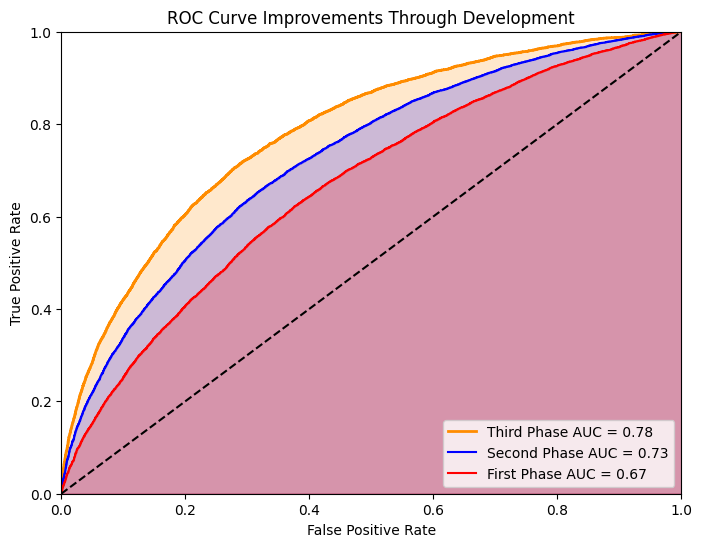

In [183]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Third Phase AUC = {final_auc:.2f}')
plt.plot(fpr_073, tpr_073, label=f'Second Phase AUC = {auc_073:.2f}', color='blue')
plt.plot(fpr_067, tpr_067, label=f'First Phase AUC = {auc_067:.2f}', color='red')
plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')  # Light shading
plt.fill_between(fpr_073, tpr_073, alpha=0.2, color='blue')  # Light shading
plt.fill_between(fpr_067, tpr_067, alpha=0.2, color='red')  # Light shading
plt.plot([0, 1], [0, 1], 'k--')  # Line for no skill classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Improvements Through Development')
plt.legend(loc="lower right")
plt.show()

In [131]:
def lgb_eval(num_leaves, max_depth, colsample_bytree, subsample, min_split_gain, min_child_weight, reg_alpha, reg_lambda):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'learning_rate': 0.01,
        'num_leaves': int(num_leaves),
        'max_depth': int(max_depth),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'verbose': -1,
        'num_iteration': 4000,
        'n_estimators': 4000
    }
    lgb_train = lgb.Dataset(data=x_train, label=y_train)
    cv_result = lgb.cv(params, lgb_train, nfold=5, seed=42, stratified=True, metrics=['auc']) 
                       #early_stopping_rounds=100, verbose_eval=False)
    return max(cv_result['auc'])

# Define the parameter bounds
param_bounds = {
    'num_leaves': (24, 60),
    'max_depth': (5, 9),
    'colsample_bytree': (0.7, 1),
    'subsample': (0.7, 1),
    'min_split_gain': (0.001, 0.1),
    'min_child_weight': (1, 10),
    'reg_alpha': (0, 0.1),
    'reg_lambda': (0, 0.1)
}

In [132]:
#optimizer = BayesianOptimization(f=lgb_eval, pbounds=param_bounds, random_state=42)
#optimizer.maximize(init_points=5, n_iter=25)

|   iter    |  target   | colsam... | max_depth | min_ch... | min_sp... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------


c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:685: UserWarning: Found 'num_iteration' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")
c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:685: UserWarning: Found 'n_estimators' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")


KeyError: 'auc'

In [133]:
#print(optimizer.max)

{}


In [ ]:
optimizer = BayesianOptimization(f=lgb_eval, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=25)

In [118]:
def lgb_cv_auc(train_X, y, lgb_params, n_splits=5, random_state=88):
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    auc_scores = []

    for train_index, val_index in kf.split(train_X, y):
        x_train_fold, x_val_fold = train_X.iloc[train_index], train_X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
        
        lgb_train_fold = lgb.Dataset(data=x_train_fold, label=y_train_fold)
        lgb_val_fold = lgb.Dataset(data=x_val_fold, label=y_val_fold)

        model = lgb.train(lgb_params, 
                          lgb_train_fold, 
                          valid_sets=[lgb_val_fold])
        
        y_pred_fold = model.predict(x_val_fold, num_iteration=model.best_iteration)
        fold_auc = roc_auc_score(y_val_fold, y_pred_fold)
        
        auc_scores.append(fold_auc)
    
    mean_auc = np.mean(auc_scores)
    return mean_auc

In [119]:
mean_auc = lgb_cv_auc(train_X, y, lgb_params, n_splits=5, random_state=88)
print("Mean AUC:", mean_auc)

c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Mean AUC: 0.782423338857102


In [59]:
lgb_model_upsampled = lgb.train(lgb_params, 
                  lgb_train_upsample, 
                  valid_sets=lgb_eval_upsample)

c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [60]:
output_predictions_to_csv(lgb_model_upsampled, 'lgb_upsampled')

,SK_ID_CURR,TARGET
0,100001,0.276477
1,100005,0.558695
2,100013,0.182266
3,100028,0.313989
4,100038,0.745802


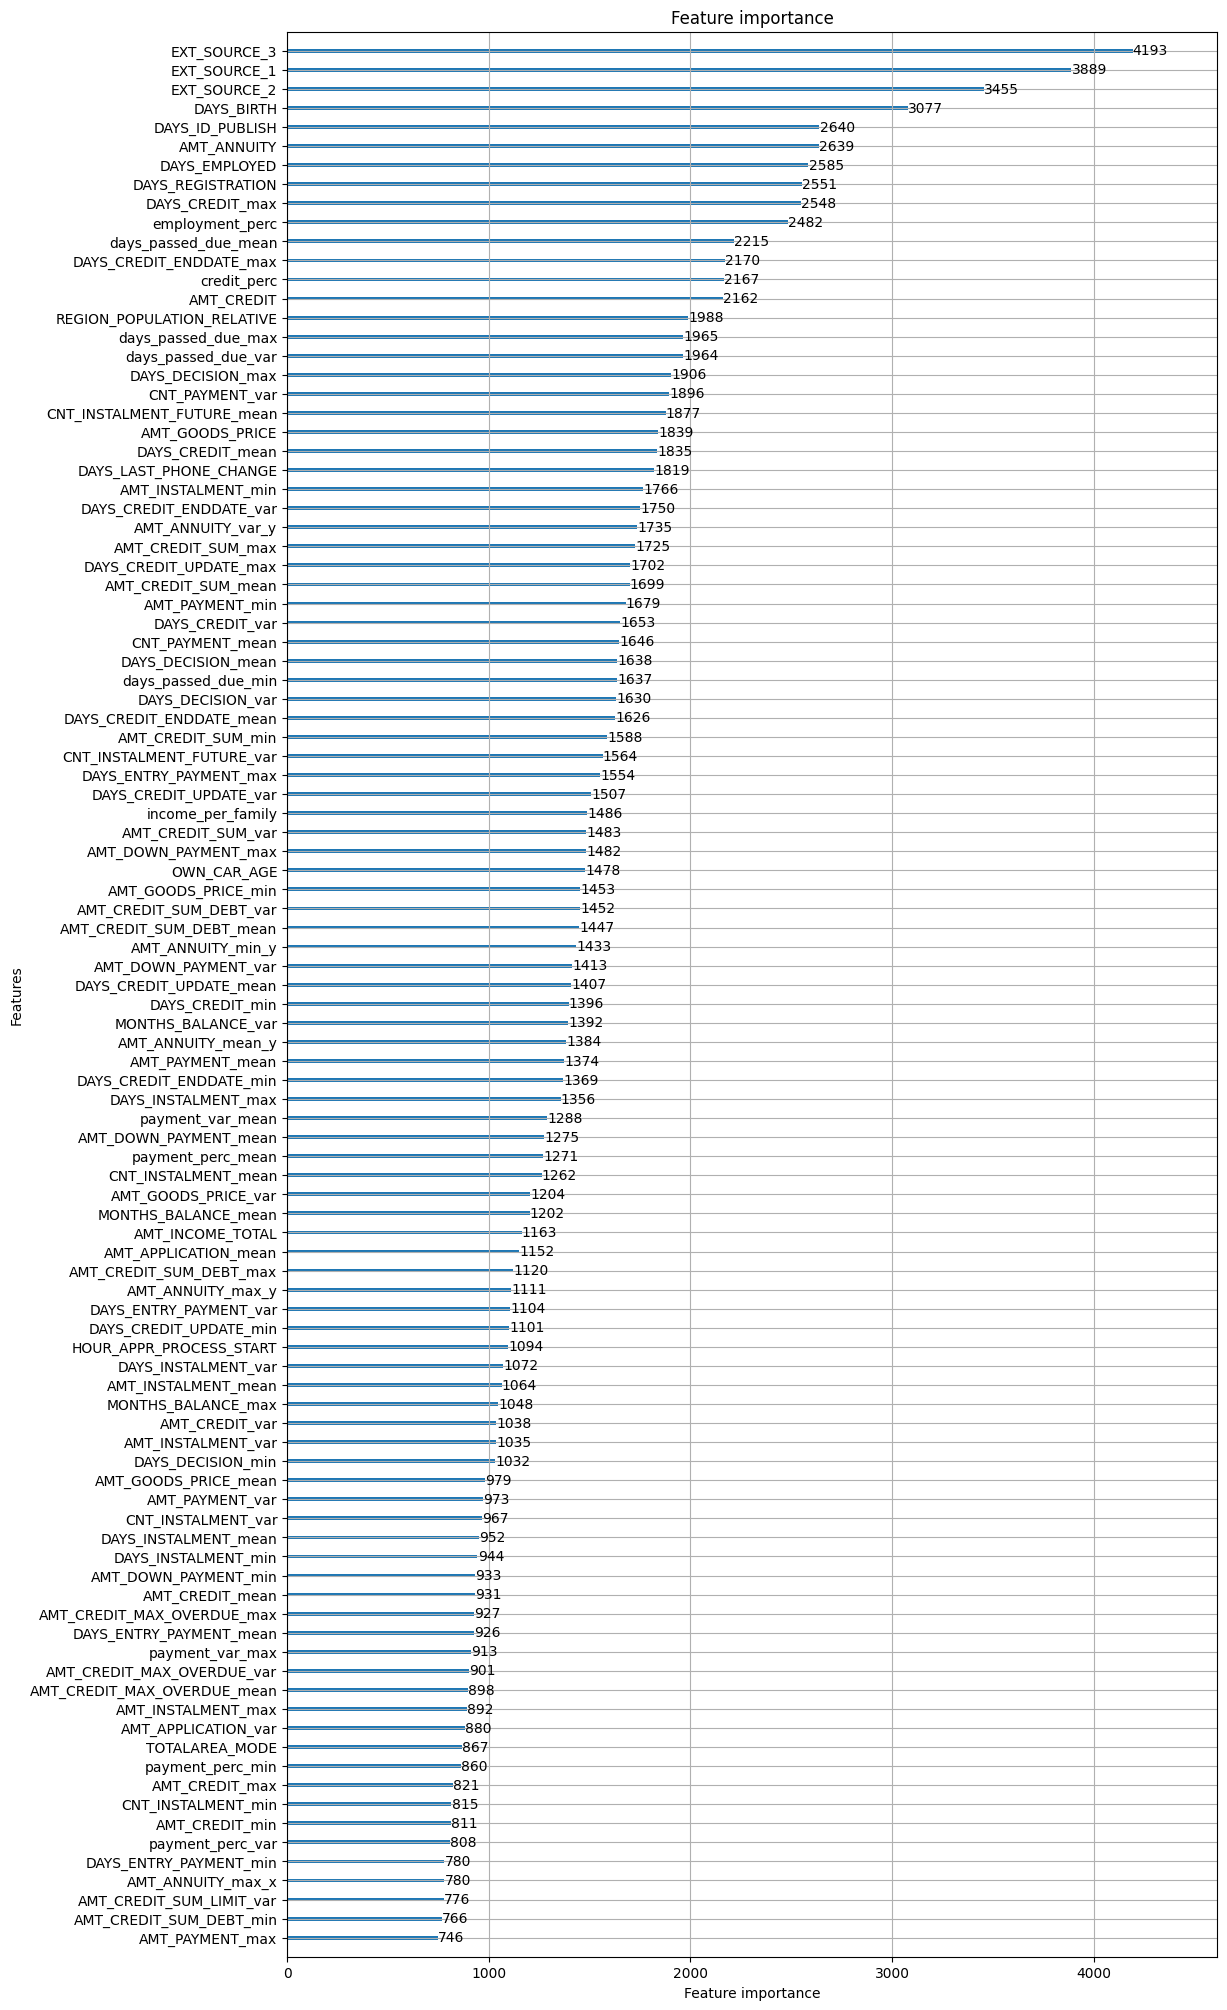

In [178]:
lgb.plot_importance(lgb_model, figsize=(12, 25), max_num_features=100);

In [124]:
preds = lgb_model.predict(test_X)
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("lgb_model.csv", index=False)
sub_lgb.head()

,SK_ID_CURR,TARGET
0,100001,0.017531
1,100005,0.128990
2,100013,0.022789
3,100028,0.051126
4,100038,0.161023


## XGBoost <a class="anchor" id="xgboost"></a>

In [ ]:
dtrain = xgb.DMatrix(data=x_train, label=y_train)
dval = xgb.DMatrix(data=x_val, label=y_val)

# Define parameters
xgb_params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'alpha': 0.1,
    'lambda': 0.1,
    'num_boost_round': 2000
}

# Train the model
xgb_model = xgb.train(xgb_params, dtrain, 
                      num_boost_round=2000, 
                      evals=[(dval, 'validation')], 
                      early_stopping_rounds=10)

c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:50:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "num_boost_round" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-auc:0.69255
[1]	validation-auc:0.72243
[2]	validation-auc:0.73267
[3]	validation-auc:0.73474
[4]	validation-auc:0.73681
[5]	validation-auc:0.73867
[6]	validation-auc:0.73927
[7]	validation-auc:0.74067
[8]	validation-auc:0.74190
[9]	validation-auc:0.74225
[10]	validation-auc:0.74222
[11]	validation-auc:0.74222
[12]	validation-auc:0.74177
[13]	validation-auc:0.74203
[14]	validation-auc:0.74227
[15]	validation-auc:0.74203
[16]	validation-auc:0.74229
[17]	validation-auc:0.74215
[18]	validation-auc:0.74228
[19]	validation-auc:0.74229
[20]	validation-auc:0.74203
[21]	validation-auc:0.74222
[22]	validation-auc:0.74207
[23]	validation-auc:0.74198
[24]	validation-auc:0.74278
[25]	validation-auc:0.74281
[26]	validation-auc:0.74349
[27]	validation-auc:0.74388
[28]	validation-auc:0.74396
[29]	validation-auc:0.74409
[30]	validation-auc:0.74411
[31]	validation-auc:0.74420
[32]	validation-auc:0.74401
[33]	validation-auc:0.74444
[34]	validation-auc:0.74483
[35]	validation-auc:0.74478
[3

In [ ]:
output_predictions_to_csv(xgb_model, 'xgb')

,SK_ID_CURR,TARGET
0,100001,0.119504
1,100005,0.136803
2,100013,0.108056
3,100028,0.115123
4,100038,0.144298


## Random Forest <a class="anchor" id="rand_f"></a>

In [ ]:
rf_model = RandomForestClassifier(n_estimators=2000, max_depth=8, random_state=88)

# Train the model
rf_model.fit(x_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict_proba(x_val)[:, 1]
print(f"Random Forest AUC: {roc_auc_score(y_val, y_pred_rf)}")

Random Forest AUC: 0.7310406438169715


In [ ]:
# something going wrong here
preds = rf_model.predict(test_X)
preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
preds = lgb_model.predict(test_X)
sub_lgb = pd.DataFrame()
sub_lgb['SK_ID_CURR'] = test_id
sub_lgb['TARGET'] = preds
sub_lgb.to_csv("lgb_model.csv", index=False)
sub_lgb.head()

In [ ]:
output_predictions_to_csv(rf_model, 'rf')

,SK_ID_CURR,TARGET
0,100001,0
1,100005,0
2,100013,0
3,100028,0
4,100038,0


## ANN <a class="anchor" id="ann"></a>

This just did not work.

In [ ]:
# # this needs some serious wokr but could be fun to mess around with

# scaler = StandardScaler()
# x_train_scaled = scaler.fit_transform(x_train)
# x_val_scaled = scaler.transform(x_val)

# # Define the model architecture
# model = Sequential([
#     Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
#     Dense(32, activation='relu'),
#     Dense(1, activation='sigmoid')  # Sigmoid activation is used for binary classification
# ])

# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# # Train the model
# history = model.fit(x_train_scaled, y_train, validation_data=(x_val_scaled, y_val), epochs=100, batch_size=256, verbose=2)

# # Predict probabilities on the validation set
# y_pred_val = model.predict(x_val_scaled)

# # Compute the AUC score
# auc_score = roc_auc_score(y_val, y_pred_val)
# print(f"Validation AUC Score: {auc_score:.4f}")

c:\Users\gbrown\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
961/961 - 8s - 8ms/step - AUC: 0.5001 - loss: 0.3489 - val_AUC: 0.5000 - val_loss: 0.2765
Epoch 2/100
961/961 - 1s - 1ms/step - AUC: 0.5004 - loss: 0.2816 - val_AUC: 0.5000 - val_loss: 0.2764
Epoch 3/100
961/961 - 1s - 1ms/step - AUC: 0.4990 - loss: 0.2816 - val_AUC: 0.5000 - val_loss: 0.2764
Epoch 4/100
961/961 - 1s - 1ms/step - AUC: 0.5015 - loss: 0.2816 - val_AUC: 0.5000 - val_loss: 0.2764
Epoch 5/100
961/961 - 1s - 1ms/step - AUC: 0.4997 - loss: 0.2816 - val_AUC: 0.5000 - val_loss: 0.2764
Epoch 6/100
961/961 - 1s - 1ms/step - AUC: 0.4990 - loss: 0.2817 - val_AUC: 0.5000 - val_loss: 0.2764
Epoch 7/100
961/961 - 1s - 1ms/step - AUC: 0.4979 - loss: 0.2817 - val_AUC: 0.5000 - val_loss: 0.2764
Epoch 8/100
961/961 - 1s - 1ms/step - AUC: 0.4984 - loss: 0.2817 - val_AUC: 0.5000 - val_loss: 0.2764
Epoch 9/100
961/961 - 1s - 1ms/step - AUC: 0.5009 - loss: 0.2817 - val_AUC: 0.5000 - val_loss: 0.2764
Epoch 10/100
961/961 - 2s - 2ms/step - AUC: 0.4990 - loss: 0.2817 - val_AUC: 0.500

KeyboardInterrupt: 